# Capstone Project - The Battle of the Neighborhoods
### Applied Data Science Capstone by IBM/Coursera

# Table of Contents
1. [Introduction: Business Problem](#introduction)
2. [Data](#data)
3. [Methodology](#methodology)
4. [Analysis](#analysis)
5. [Results and Discussion](#results)
6. [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

There are many reasons people move to large cities. They might move because they have a better job opportunity, or because there are more options for professionals in areas with a greater concentration of offices and people. If you live and work in the city, you generally enjoy lower commute times. Perhaps you may just be a people person and there is something about being surrounded by people 24/7 that attracts you to high-density areas.

A reason often cited for going to cities is the proximity to good entertainment, food and attractions. In a higher population area, it makes sense that there would be more businesses open to service the population. However, some people go further and paint the increase in attractions as a reflection of the cultural diversity within an area. Since a higher number of businesses increases tourism and traffic to an area (and tourism and traffic increase the profitability of opening new businesses), this goes to say that cultural diversity can be beneficial to a city's economy.

This study will examine Toronto location and demographic data to determine if the number of businesses open in an area are in fact a result of demographic diversity. We will do this by seeing if there is an impact of population characteristics (i.e. population, age, income and language as a measure of cultural diversity) on the number of restaurants in an area. If, after controlling for population density, there are still significant impacts of age, income and cultural diversity, then this could indicate that there is some economic value to be found in incentivizing certain groups to move to cities.

## Data <a name="data"></a>

In order to conduct our analysis, we will be looking at a cross-section of Toronto neighbourhoods where we have information on the number of restaurants in each area and various demographic characteristics of each area including age groups, income groups, native languages and population density.

We will be using four main data sources:

**1) List of Toronto neighbourhoods and postal codes (source: Wikipedia, [url](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M))**

This table contains all Toronto postal codes starting with M (hereby known as boroughs) and the underlying neighbourhoods. These data were retrieved from the Canada Post website, according to the Wikipedia citations.

**2) Latitude and Longitude coordinates for Toronto neighbourhoods (source: IBM)**

This dataset lists the latitude and longitude coordinates for each of the Toronto neighbourhoods. It can be found in a CSV file.

**3) Foursquare location data, retrieved through an API (source: Foursquare)**

These data contain venue locations according to each of the neighbourhood latitude and longitude coordinates obtained in the second dataset. We will be using this dataset to find all the restaurants within a specific neighbourhood.

**4) Toronto Census Data (source: City of Toronto, [url](https://open.toronto.ca/dataset/neighbourhood-profiles/))**

This dataset can be downloaded off the City of Toronto website and contains aggregated demographic data on each of the city's neighbourhoods. Collected in 2016, this data was collected at the last nationwide census and includes information such as age, gender, languages spoken, income and population. Age, languages spoken and income are represented as percentage of the total respondents. We will be using this dataset for the the population density per square km, proportion of individuals from each age and income group and the proportion of individuals from each age and income group and the proportion of non-native English/French speakers.

The overall dataset is a cross-section of 20 neighbourhoods that appear both in the list of Toronto neighbourhoods and postal codes and in the census data.


We install all necessary packages.

In [12]:
!pip install requests
!pip install html5lib
!pip install bs4
from bs4 import BeautifulSoup
import requests

import matplotlib.pyplot as plt
import pandas as pd
import pylab as pl
import numpy as np
%matplotlib inline
from sklearn import datasets, linear_modelodel
from sklearn import metrics
!pip install statsmodels --upgrade
from scipy import stats

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


We scrape the Toronto neighbourhoods dataset from Wikipedia. This dataset contains postal codes, borough and neighbourhoods names. We also merge this scraped dataset with the provided Toronto latitude and longitude data.

In [14]:
URL = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
html = requests.get(URL)
soup = BeautifulSoup(html.content, 'html5lib')

table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

# print(table_contents)
df_toronto =pd.DataFrame(table_contents)
df_toronto['Borough']=df_toronto['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

lat_lon = pd.read_csv(r"C:\Users\siqm\Downloads\Geospatial_Coordinates.csv")
lat_lon = lat_lon.rename(columns = {'Postal Code': 'PostalCode'})

df_toronto = pd.merge(df_toronto, lat_lon, on = 'PostalCode')
df_toronto.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


We read in the census data obtained from the City of Toronto website and merge it on boroughs with the original dataset.

In [15]:
census_data = pd.read_csv(r"C:\Users\siqm\Downloads\toronto_data.csv")
census_data.dropna(how='all', axis=1, inplace=True)

df_toronto = pd.merge(df_toronto, census_data, on = 'Neighborhood')
df_toronto.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Pop_density,Age_0_14,Age_15_24,Age_25_54,Age_55_64,...,Inc_45000_49999,Inc_50000_59999,Inc_60000_69999,Inc_70000_79999,Inc_80000_89999,Inc_90000_99000,Inc_100000_199999,Inc_200000,Inc_0_50000,Inc_50000_over
0,M3A,North York,Parkwoods,43.753259,-79.329656,4691,0.164,0.131,0.415,0.120,...,0.045272,0.087623,0.074845,0.064257,0.057685,0.047463,0.277108,0.064987,0.326031,0.673969
1,M4A,North York,Victoria Village,43.725882,-79.315572,3710,0.146,0.112,0.397,0.126,...,0.059901,0.090204,0.080338,0.069063,0.054264,0.040874,0.203665,0.033827,0.427766,0.572234
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,16880,0.150,0.163,0.513,0.101,...,0.044539,0.083775,0.076352,0.054083,0.046660,0.037116,0.158006,0.031813,0.512195,0.487805
3,M6C,York,Humewood-Cedarvale,43.693781,-79.428191,7682,0.148,0.110,0.478,0.113,...,0.042254,0.071831,0.060563,0.050704,0.038732,0.033803,0.288028,0.131690,0.324648,0.675352
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,6058,0.175,0.095,0.439,0.144,...,0.025821,0.044639,0.039825,0.038950,0.037637,0.035449,0.414880,0.198249,0.190372,0.809628


We put in our credentials for the Foursquare API to obtain information on all venues within each neighbourhood. Here, we define the function to pull the venues in each borough from the API.

In [16]:
CLIENT_ID = 'CVSUDURB54AQFHZE55RFYO3QT5Z4DZCFYZMNWWYNCCR2KKRZ' # your Foursquare ID
CLIENT_SECRET = 'LUSTZ5KPZFXKXXD44FLGB1GORLIBYUOOX5JV5B2JFME1ZMCH' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

We use the defined function to generate a dataset compiling the venues for each neighbourhood.

In [25]:
# Find number of venues for each neighbourhood
toronto_data = {}
toronto_venues = {}
for name in df_toronto["Borough"].unique():   
    toronto_data[name] = df_toronto[df_toronto['Borough'].str.contains(name)].reset_index(drop=True)

    toronto_venues[name] = getNearbyVenues(names=toronto_data[name]['Neighborhood'],
                                   latitudes=toronto_data[name]['Latitude'],
                                   longitudes=toronto_data[name]['Longitude']
                                  )
toronto_venues['North York'].head()    

Parkwoods
Victoria Village
Hillcrest Village
Bayview Village
Humber Summit
Willowdale West
Regent Park, Harbourfront
Parkwoods
Victoria Village
Humewood-Cedarvale
Hillcrest Village
Thorncliffe Park
Bayview Village
Humber Summit
Weston
Willowdale West
The Beaches
Woburn
Scarborough Village
Thorncliffe Park


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,KFC,43.754387,-79.333021,Fast Food Restaurant
2,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


We reshape the venues dataset so that there is a dummy variable for each type of venue. We then merge this with the original data to get a cross-section of neighbourhoods and the venues in each.

In [45]:
toronto_onehot = {}
toronto_grouped = {}
col = {}
matching = {}

for name in df_toronto["Borough"].unique(): 
    # one hot encoding
    toronto_onehot[name] = pd.get_dummies(toronto_venues[name][['Venue Category']], prefix="", prefix_sep="")

    # add neighborhood column back to dataframe
    toronto_onehot[name]['Neighborhood'] = toronto_venues[name]['Neighborhood'] 

    toronto_grouped[name] = toronto_onehot[name].groupby('Neighborhood').sum().reset_index()
    
    # Merge raw data with venues data
    toronto_grouped[name] = pd.merge(toronto_data[name], toronto_grouped[name], on = 'Neighborhood')
    
    # Keep restaurants only
    col[name] = list(toronto_grouped[name].columns.values)
    matchers = ['Restaurant','Neighborhood','Lan','Inc','Pop','Age']
    matching[name] = [s for s in col[name] if any(xs in s for xs in matchers)]
    
    toronto_grouped[name] = toronto_grouped[name][matching[name]]
    
toronto_grouped['North York'].head()

,Neighborhood,Pop_density,Age_0_14,Age_15_24,Age_25_54,Age_55_64,Age_65_84,Age_85,Age_young,Age_old,...,Inc_100000_199999,Inc_200000,Inc_0_50000,Inc_50000_over,Chinese Restaurant,Fast Food Restaurant,French Restaurant,Japanese Restaurant,Mediterranean Restaurant,Portuguese Restaurant
0,Parkwoods,4691,0.164,0.131,0.415,0.120,0.148,0.022,0.711,0.289,...,0.277108,0.064987,0.326031,0.673969,0,1,0,0,0,0
1,Victoria Village,3710,0.146,0.112,0.397,0.126,0.188,0.032,0.654,0.346,...,0.203665,0.033827,0.427766,0.572234,0,0,1,0,0,1
2,Hillcrest Village,3148,0.121,0.124,0.345,0.129,0.245,0.036,0.590,0.410,...,0.351030,0.076070,0.296355,0.703645,0,1,0,0,1,0
3,Bayview Village,4195,0.110,0.114,0.469,0.115,0.164,0.028,0.692,0.308,...,0.299652,0.085117,0.323046,0.676954,1,0,0,1,0,0
4,Humber Summit,1570,0.170,0.136,0.383,0.104,0.188,0.020,0.688,0.312,...,0.247449,0.029337,0.375000,0.625000,0,0,0,0,0,0


We combine the individual datasets from each borough into one large dataset.

In [46]:
boroughs = list(toronto_grouped.keys())
first = boroughs[0]
print(boroughs)
boroughs.pop(0)

df_combined = toronto_grouped[first]

for b in boroughs:
    df_combined = df_combined.append(toronto_grouped[b])

['North York', 'Downtown Toronto', 'York', 'East Toronto', 'Scarborough', 'East York']


We collapse into the number of restaurants per neighbourhood and drop any duplicates.

In [47]:
df_combined['Sum'] = df_combined[cols_restaurants].sum(axis=1)

df_combined.drop(cols_restaurants, axis=1, inplace = True) # Drop extra columns
df_combined.drop_duplicates(inplace = True)

## Analysis <a name="analysis"></a>

We generate some summary statistics in order to get a higher-level overview of how the neighbourhoods differ. From the table below, we can see that there are some neighbourhoods that are a lot denser such as Regent Park/Harbourfront which is in the Downtown Toronto borough. Thorncliffe Park is the lowest-income neighbourhood where 50% of the population's households earn less than $50,000. There are also a few neighbourhoods that have zero restaurants. 

# Some Tables

In [48]:
byneighborhood = df_combined.groupby('Neighborhood')[['Neighborhood','Pop_density', 'Age_young', 'Age_old', \
                                                      'Lang_native', 'Lang_foreign', 'Inc_0_50000', 'Inc_50000_over', \
                                                     'Sum']]
byneighborhood.head()

,Neighborhood,Pop_density,Age_young,Age_old,Lang_native,Lang_foreign,Inc_0_50000,Inc_50000_over,Sum
0,Parkwoods,4691,0.711,0.289,0.971691,0.028165,0.326031,0.673969,1.0
1,Victoria Village,3710,0.654,0.346,0.957546,0.041873,0.427766,0.572234,2.0
2,Hillcrest Village,3148,0.590,0.410,0.906915,0.092199,0.296355,0.703645,2.0
3,Bayview Village,4195,0.692,0.308,0.956000,0.044000,0.323046,0.676954,2.0
4,Humber Summit,1570,0.688,0.312,0.919790,0.079807,0.375000,0.625000,0.0
5,Willowdale West,5820,0.653,0.347,0.942274,0.058022,0.357284,0.642716,0.0
0,"Regent Park, Harbourfront",16880,0.827,0.173,0.941039,0.058961,0.512195,0.487805,5.0
2,Humewood-Cedarvale,7682,0.736,0.264,0.986653,0.013347,0.324648,0.675352,0.0
4,Thorncliffe Park,6787,0.793,0.207,0.936466,0.064013,0.500000,0.500000,5.0
7,Weston,7197,0.713,0.287,0.963611,0.036671,0.480647,0.519353,0.0


Here we plot some relationships between the dependent variable, number of restaurants, and the various independent variables (population density, income proportion, age proportion and non-native English/French speaker proportion). Aside from the zero observations, there seems to be a positive correlation between the number of restaurants and population density and proportion of non-native English/French speakers. There is also a weak negative correlation between the number of restaurants and the proportion of high-income households. We will see how these relationships change when we include them all in one regression. It is possible that these demographic variables are correlated (younger people may have more income, for example) so that the correlation, *after controlling for confounding variables* may switch.

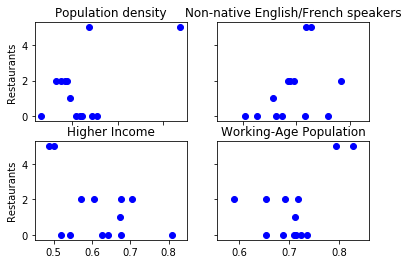

In [59]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].scatter(df_combined.Pop_density, df_combined.Sum,  color='blue')
axs[0, 0].set_title('Population density')
axs[0, 1].scatter(df_combined.Lang_foreign, df_combined.Sum,  color='blue')
axs[0, 1].set_title('Non-native English/French speakers')
axs[1, 0].scatter(df_combined.Inc_50000_over, df_combined.Sum,  color='blue')
axs[1, 0].set_title('Higher Income')
axs[1, 1].scatter(df_combined.Age_young, df_combined.Sum,  color='blue')
axs[1, 1].set_title('Working-Age Population')

for ax in axs.flat:
    ax.set(xlabel='', ylabel='Restaurants')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

## Methodology <a name="methodology"></a>

In this project, we are attempting to determine the impact of cultural diversity on the number of restaurants in an area. Due to data limitations, we proxy cultural diversity using the proportion of non-native English or French speakers. Inevitably, there are other factors that may affect the number of restaurants. Based on the data we have, we are adding proportion of high-income households, proportion of working-age population and population density as covariates. The greater the proportion of high-income households, the wealthier a neighbourhood is. We may expect wealthier neighbourhoods to have more restaurants as people in these areas have more disposable income to spend on eating out. Neighbourhoods with a larger working-age population (ages 15-55) may also have more disposable income to spend. Younger individuals also tend to go out more than their older counterparts. Finally, a higher population density means that there is a larger customer base and higher demand for restaurants. In order to meet demand, we would expect a higher supply of restaurants as well. For these reasons, we are including income, age and population density as controls in our linear regression.

Once we have collected the number of restaurants within each neighbourhood, we run an OLS regression to determine the impact of demographic factors on the number of restaurants in an area. This is shown in the below equation:

${Restaurants}_{j} = {\beta}_{0} + {\beta}_{1}popdensity_{j} + {\beta}_{2}ageyoung_{j} + {\beta}_{3}inchigh_{j} + {\beta}_{4}langforeign_{j} + {\epsilon}_{j} $

where *j* is a neighbourhood in Toronto, *popdensity* is the population density per square km, *ageyoung* is the proportion of individuals between 15 and 55 years old, *inchigh* is the proportion of households making over $50000/year and *langforeign* is the proportion of individuals not speaking English or French as a first language.

The coefficient we are particularly interested in is ${\beta}_{4}$, which indicates the impact of cultural diversity on the number of restaurants. Here, we use not speaking English or French as a first language as a proxy of cultural diversity since we do not have immigration or ethnic background information in our dataset.

It is important to note that we do not run the regression on a testing and training set as our combined dataset only has 20 different observations. If we were to split our dataset further, this would further increase the standard errors of our estimates, thus decreasing the precision. This will hurt interpretation of the statistical validity of our results. In the end, our goal is not to predict the number of restaurants in the area, it is just to test whether there is an impact of the proportion of non-native English/French speakers on the number of restaurants.

Below, we run a multiple linear regression as shown in the above equation.

In [77]:
lm = linear_model.LinearRegression()
x = np.asanyarray(df_combined[['Pop_density','Age_young','Inc_50000_over','Lang_foreign']])
y = np.asanyarray(df_combined[['Sum']])

lm.fit(x,y)
params = np.append(lm.intercept_,lm.coef_)
predictions = lm.predict(x)

newX = pd.DataFrame({"Constant":np.ones(len(x))}).join(pd.DataFrame(x))
MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))

var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params/ sd_b

p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(newX[0])))) for i in ts_b]

sd_b = np.round(sd_b,3)
ts_b = np.round(ts_b,3)
p_values = np.round(p_values,3)
params = np.round(params,4)

myDF3 = pd.DataFrame()
myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["Probabilities"] = [params,sd_b,ts_b,p_values]
print(myDF3)

# Model Evaluation
y_hat= lm.predict(df_combined[['Pop_density','Age_young','Inc_50000_over','Lang_foreign']])
r2 = metrics.r2_score(y, y_hat)

# Explained variance score: 1 is perfect prediction
#print('R-squared: %.2f' % r2)
print('Variance score: %.2f' % lm.score(x, y))

   Coefficients  Standard Errors  t values  Probabilities
0      -13.2330           11.068    -1.196            NaN
1        0.0001            0.000     0.636            NaN
2       16.1465           12.055     1.339            NaN
3        1.0873            6.187     0.176            NaN
4       42.6274           20.105     2.120            NaN
Variance score: 0.59


## Results and Discussion <a name="results"></a>

Somewhat unexpectedly, there is a small, albeit positive, coefficient on population density. This means that after controlling for other demographic factors, there is almost no correlation between having a higher amount of people living in a given area does not necessarily lead to a higher number of restaurants. We had previously hypothesized that this coefficient would be positive and significant due to higher demand for restaurants. One possible explanation for this is that higher density areas have more land dedicated to residential buildings and less to commercial buildings (where restaurants are). Some neighbourhoods will have more restaurants to meet the demand, but in other neighbourhoods, the supply is limited.

There are also positive coefficients on the working-age proportion and higher-income proportions. Although these coefficients are not significant at the 5% level, they have larger magnitudes than the coefficient on population density. This aligns with our hypothesis that these two populations would have larger disposable incomes and would be able to spend more on restaurants. However, this is a two-way correlation as younger and higher-income people might tend to move into areas with more restaurants.

The largest and only significant coefficient belonged to our proxy of cultural diversity: the proportion of non-native English/French speakers. This coefficient was significant at the 5% level, meaning that having a higher number of ethnically diverse constituents within the neighbourhood has a positive impact on the number of restaurants in a neighbourhood. This could be explained by those who do not speak an official language well choosing to open up their own businesses instead of pursuing the job market. Those with different cultural backgrounds also tend to fare better in the restaurant business due to them having a unique cuisine and selling point.

For an economic model, the R-squared is not unreasonably low - it sits at 0.59. However, except for the language variable, none of the variables were significant at the 5% level which means that statistically, they did not have a lot of explanatory power. One possible explanation is that the cross-section only consists of 20 neighbourhoods. When the number of observations is that low, standard errors tend to go up which can deflate the statistical significance of estimates. It is also possible that with a larger sample, the coefficients themselves might change.

Given our limited data, it also would have been helpful to be able to control for other variables. For example, places with many offices or easy access to transit may have more businesses and restaurants due to a larger customer base so that we may want to control for these type of venues. As well, crime rates, tax policies and rents may also affect the number of restaurants in an area. Including these covariates would make the findings of this study more robust.

## Conclusion <a name="conclusion"></a>

Through measuring cultural diversity through its proxy of non-native speakers of English and French, we see a positive impact of cultural diversity on the number of restaurants within an area. Increasing the number of restaurants has economic and social benefits for a neighbourhood. It not only is a place where inhabitants can spend money and boost the economy, it can also encourage people (and tourists) to visit the area. Moreover, economically speaking, more restaurants lead to more choices for consumers which allow consumers to choose what benefits them the most (whether it be having a type of food they like or getting a lower cost). This increases the social welfare of people living and visiting a particular neighbourhood.

For immigration policy-makers, this study helps in forming an economic argument why immigration and the resulting multiculturalism are good for Toronto (and cities in general). In order to make the findings more robust, policy-makers will have to include more controls and experiment with various regression forms, however it is a starting point for more study in this area.